In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import json
import pandas as pd
import re
import os
import sys
import pickle

In [3]:
try:
    from get_splits_minimal import get_splits_for_linear_probe
    from eval_linear_probe import train_and_evaluate_logistic_regression_with_val, train_and_evaluate_logistic_regression
    from utils import bootstrap
    print("Successfully imported package")
except ImportError as e:
    print(f"Error importing package: {e}")

Successfully imported package


In [5]:
(train_X, train_y), (val_X, val_y), (test_X, test_y),split = get_splits_for_linear_probe(
    skl_path='../data/embeddings_df.pkl',
    # skl_path='/content/gdrive/MyDrive/Capstone Code/supcon testing/data/pgr_dpo_epoch40_beta0.5_lr1e-4_best_1.pkl',
    csv_path='../data/PGR_manifest.csv',
    biomarker='PGR'
)

Loading embeddings from ../data/embeddings_df.pkl
Loaded 11658 slide embeddings
Embedding dimension: (768,)

Normalizing embeddings...
âœ“ Normalized 11658 embeddings
Loading clinical data from ../data/PGR_manifest.csv
Loaded 992 samples

SIMPLE RANDOM SLIDE-LEVEL SPLITTING
Split ratios: Train ~50%, Val ~25%, Test 25%

TRAIN:
  Slides: 496 (50.0%)
  Patients: 481
  Distribution: {'negative': 157, 'positive': 339}

VAL:
  Slides: 248 (25.0%)
  Patients: 244
  Distribution: {'negative': 78, 'positive': 170}

TEST:
  Slides: 248 (25.0%)
  Patients: 240
  Distribution: {'negative': 78, 'positive': 170}
  Converting string labels to binary...
PGR distribution: {'negative': 157, 'positive': 339}
Total slides: 496
  Converting string labels to binary...
PGR distribution: {'negative': 78, 'positive': 170}
Total slides: 248
  Converting string labels to binary...
PGR distribution: {'negative': 78, 'positive': 170}
Total slides: 248


In [6]:
slide_feature_path = "../data/embeddings_df.pkl"
with open(slide_feature_path, 'rb') as file:
  data = pickle.load(file)
embeddings_df = pd.DataFrame({'slide_id': data['slide_id'], 'embeddings': list(data['embeddings'][:])})

In [6]:
PGR_manifest = pd.read_csv('../data/PGR_manifest.csv')
PGR_manifest

,slide_id,submitter_id,project_id,sex,OncoTreeCode,OncoTreeSiteCode,site,source_site,PGR
0,TCGA-A2-A0CQ-01Z-00-DX1.4E5FB4E5-A08C-4C87-A3B...,TCGA-A2-A0CQ,TCGA-BRCA,F,IDC,BREAST,A2,Walter Reed,positive
1,TCGA-GM-A2DI-01Z-00-DX1.5E9715EA-9D2B-49D0-8F1...,TCGA-GM-A2DI,TCGA-BRCA,F,IDC,BREAST,GM,University of Texas MD Anderson Cancer Center,negative
2,TCGA-E2-A152-01Z-00-DX1.B0860DEB-D34B-4C5D-97F...,TCGA-E2-A152,TCGA-BRCA,F,IDC,BREAST,E2,Roswell Park,negative
3,TCGA-BH-A1FH-01Z-00-DX1.F90A691F-B6DB-4C4A-997...,TCGA-BH-A1FH,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,negative
4,TCGA-BH-A0DS-01Z-00-DX1.38E82A1F-21B9-4B97-A30...,TCGA-BH-A0DS,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,positive
...,...,...,...,...,...,...,...,...,...
987,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,TCGA-3C-AALK,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive
988,TCGA-A7-A13E-01Z-00-DX1.891954FF-316A-4562-AA1...,TCGA-A7-A13E,TCGA-BRCA,F,IDC,BREAST,A7,Christiana Healthcare,negative
989,TCGA-A7-A13E-01Z-00-DX2.1E1262AE-A32D-4814-94A...,TCGA-A7-A13E,TCGA-BRCA,F,IDC,BREAST,A7,Christiana Healthcare,negative
990,TCGA-HN-A2OB-01Z-00-DX1.14F1FBFB-4540-43CE-9D7...,TCGA-HN-A2OB,TCGA-BRCA,F,ILC,BREAST,HN,Ontario Institute for Cancer Research (OICR),positive


In [7]:
pgr_df = pd.merge(embeddings_df, PGR_manifest, on='slide_id')

In [8]:
pgr_df

,slide_id,embeddings,submitter_id,project_id,sex,OncoTreeCode,OncoTreeSiteCode,site,source_site,PGR
0,TCGA-AO-A0J2-01Z-00-DX1.7C9FEC7B-6040-4C58-956...,"[0.5107422, -0.3881836, 0.14489746, 0.02661132...",TCGA-AO-A0J2,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,negative
1,TCGA-AO-A0J3-01Z-00-DX1.8F28BFC8-D37E-425F-A9E...,"[0.4921875, 0.0317688, 0.30932617, -0.23205566...",TCGA-AO-A0J3,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,positive
2,TCGA-BH-A0DO-01Z-00-DX1.1684557E-A5D4-4828-B2D...,"[0.73828125, -0.29882812, -0.42456055, 0.07226...",TCGA-BH-A0DO,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,positive
3,TCGA-BH-A0DP-01Z-00-DX1.5550557D-4E5B-4B57-8C1...,"[0.7866211, -0.8105469, -0.18664551, -0.055938...",TCGA-BH-A0DP,TCGA-BRCA,F,ILC,BREAST,BH,University of Pittsburgh,positive
4,TCGA-BH-A0DT-01Z-00-DX1.73AFCEBB-06B1-4870-ADA...,"[0.43139648, 0.040008545, -0.048095703, 0.0200...",TCGA-BH-A0DT,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,positive
...,...,...,...,...,...,...,...,...,...,...
987,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,"[1.1025391, 0.24084473, -0.27319336, 0.1853027...",TCGA-3C-AALI,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive
988,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,"[0.74316406, 0.44628906, -0.24963379, -0.08148...",TCGA-3C-AALK,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive
989,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,"[1.0136719, 0.13891602, -0.1887207, 0.21289062...",TCGA-3C-AALI,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive
990,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,"[1.2412109, 0.37182617, 0.19213867, -0.1798095...",TCGA-3C-AALJ,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive


In [9]:
val_X

array([[ 0.51464844, -0.36376953,  0.17651367, ...,  0.5361328 ,
         0.796875  ,  0.32470703],
       [ 0.5917969 ,  0.46289062, -0.3942871 , ..., -0.07556152,
         0.6538086 ,  0.52490234],
       [ 0.5415039 , -0.7319336 , -0.27563477, ...,  0.15600586,
         1.1191406 , -0.02748108],
       ...,
       [ 0.37304688, -0.7973633 , -0.17944336, ..., -0.02798462,
         0.73583984,  0.21984863],
       [ 0.7973633 , -1.3359375 , -0.16870117, ...,  0.5263672 ,
         0.5732422 , -0.00905609],
       [ 0.51464844, -0.40429688, -0.03201294, ..., -0.56933594,
         0.19836426, -0.54589844]], dtype=float32)

Finding best C: 100%|██████████| 45/45 [00:06<00:00,  7.05it/s]


Best C: 56.23413251903491


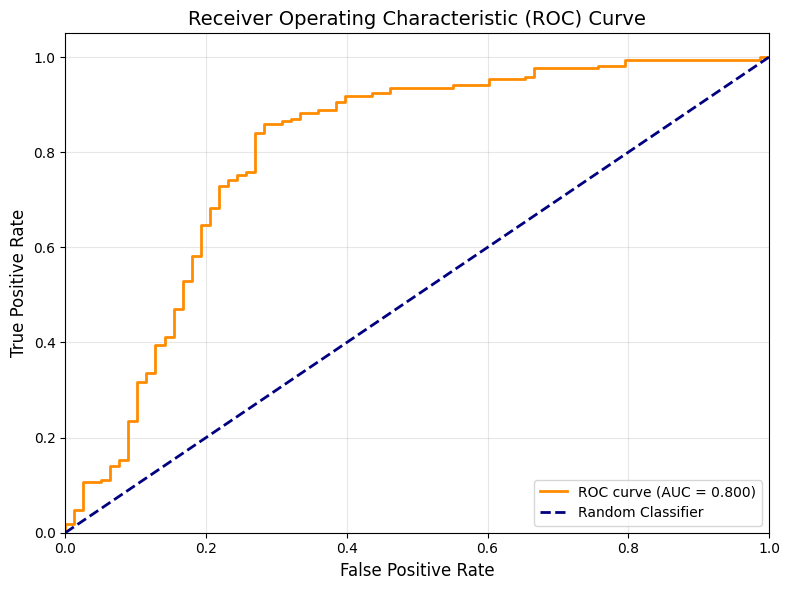

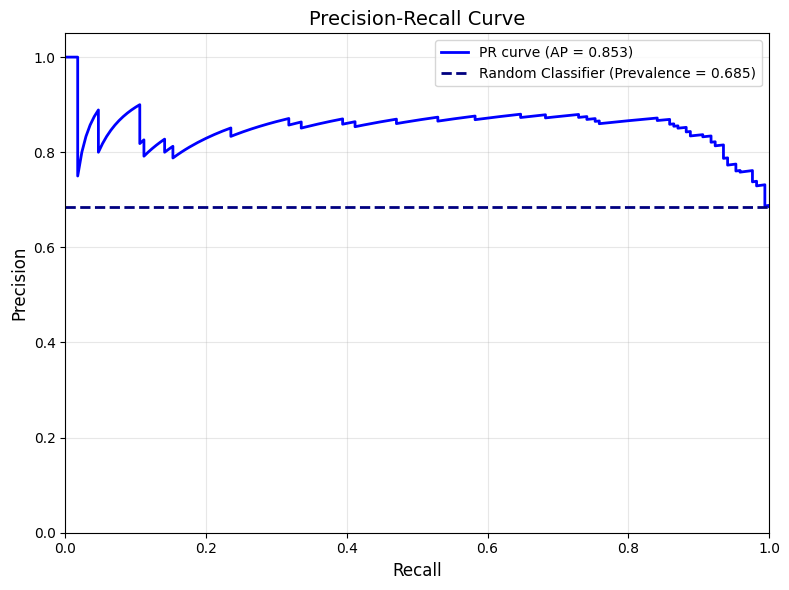

In [10]:
import numpy as np
log_spaced_values = np.logspace(np.log10(10e-6), np.log10(10e5), num=45)
metrics, outputs = train_and_evaluate_logistic_regression_with_val(
    train_data=train_X,
    train_labels=train_y,
    val_data=val_X,
    val_labels=val_y,
    test_data=test_X,
    test_labels=test_y,
     log_spaced_values=log_spaced_values
)

In [11]:
metrics

{'/acc': 0.7903225806451613,
 '/bacc': 0.7048265460030165,
 '/kappa': 0.4572390572390572,
 '/nw_kappa': 0.4572390572390572,
 '/weighted_f1': 0.7738614190227093,
 '/loss': 0.47946651818999225,
 '/auroc': 0.7998491704374057,
 '/auprc': 0.8532087795588155}

In [12]:
bootstrap_kwargs = {'n': 1000, 'alpha': 0.95}
results_mean, results_std = bootstrap(results_dict=outputs, **bootstrap_kwargs)  # takes a while as 46 imbalanced classes are bootstrapped
for keys, values in results_mean.items():
    print(f"{keys.split('/')[-1]: <12}: {values:.4f} ± {results_std[keys]:.4f}")

100%|██████████| 1000/1000 [00:15<00:00, 66.15it/s]

acc         : 0.7896 ± 0.0263
bacc        : 0.7040 ± 0.0312
kappa       : 0.4540 ± 0.0645
nw_kappa    : 0.4540 ± 0.0645
weighted_f1 : 0.7729 ± 0.0297
loss        : 0.4814 ± 0.0361
auroc       : 0.7975 ± 0.0346
auprc       : 0.8528 ± 0.0341


## Only Validation

In [12]:
import numpy as np
log_spaced_values = np.logspace(np.log10(10e-6), np.log10(10e5), num=45)
results, outputs = train_and_evaluate_logistic_regression(train_X, train_y, val_X, val_y, log_spaced_values=log_spaced_values)

Finding best C via CV: 100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

Best C: 56.23413251903491 (CV score: -0.4826)


In [13]:
results

{'/acc': 0.8064516129032258,
 '/bacc': 0.744343891402715,
 '/kappa': 0.5212355212355213,
 '/nw_kappa': 0.5212355212355213,
 '/weighted_f1': 0.7986946335806687,
 '/loss': 0.48714244879190527,
 '/auroc': 0.7889140271493214}

In [14]:
outputs = pd.DataFrame(outputs)

In [15]:
outputs['Predicts'] = outputs['targets'] == outputs['preds']
outputs

,targets,preds,probs,Predicts
0,0,1,0.782126,False
1,0,1,0.862018,False
2,0,1,0.890643,False
3,0,0,0.261160,True
4,1,1,0.790747,True
...,...,...,...,...
243,1,1,0.653664,True
244,1,0,0.123757,False
245,0,1,0.798069,False
246,1,1,0.773516,True


In [23]:
val_df = pd.DataFrame({
    'slide_id': split["val"]
})


pgr_val = pgr_df[pgr_df['slide_id'].isin(split["val"])].copy()


val_df = pgr_val.merge(val_df, on='slide_id', how='inner')


In [24]:
val_df

,slide_id,embeddings,submitter_id,project_id,sex,OncoTreeCode,OncoTreeSiteCode,site,source_site,PGR
0,TCGA-BH-A0DP-01Z-00-DX1.5550557D-4E5B-4B57-8C1...,"[0.7866211, -0.8105469, -0.18664551, -0.055938...",TCGA-BH-A0DP,TCGA-BRCA,F,ILC,BREAST,BH,University of Pittsburgh,positive
1,TCGA-AO-A0JB-01Z-00-DX1.250FE098-345B-4981-923...,"[0.6982422, -0.5307617, -0.09173584, 0.0744018...",TCGA-AO-A0JB,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,positive
2,TCGA-AO-A0JD-01Z-00-DX1.52E3DCE8-32E3-45C0-AB5...,"[0.6816406, -0.4326172, -0.090026855, -0.11486...",TCGA-AO-A0JD,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,positive
3,TCGA-AO-A0JL-01Z-00-DX1.473CC200-221A-4777-B19...,"[0.6538086, 0.0052833557, 0.05041504, 0.145751...",TCGA-AO-A0JL,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,negative
4,TCGA-BH-A0EE-01Z-00-DX1.872EA586-25C8-4835-A13...,"[0.007827759, 0.7788086, 0.7949219, -0.3649902...",TCGA-BH-A0EE,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,negative
...,...,...,...,...,...,...,...,...,...,...
243,TCGA-S3-AA12-01Z-00-DX1.2A991B9F-E7E6-410B-B0B...,"[0.07897949, 0.0041618347, 0.16491699, 0.10308...",TCGA-S3-AA12,TCGA-BRCA,F,IDC,BREAST,S3,Albert Einstein Medical Center,negative
244,TCGA-PE-A5DE-01Z-00-DX1.88B354F2-5485-44AA-A05...,"[0.6015625, -0.5566406, -0.25512695, 0.4067382...",TCGA-PE-A5DE,TCGA-BRCA,F,ILC,BREAST,PE,Fox Chase,positive
245,TCGA-PE-A5DD-01Z-00-DX1.E1EF11EC-B87B-49DE-A54...,"[0.87939453, -0.9394531, -0.37402344, 0.419677...",TCGA-PE-A5DD,TCGA-BRCA,F,ILC,BREAST,PE,Fox Chase,negative
246,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,"[1.0136719, 0.13891602, -0.1887207, 0.21289062...",TCGA-3C-AALI,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive


In [25]:
validation = val_df.merge(outputs, left_index=True, right_index=True)

In [26]:
validation

,slide_id,embeddings,submitter_id,project_id,sex,OncoTreeCode,OncoTreeSiteCode,site,source_site,PGR,targets,preds,probs,Predicts
0,TCGA-BH-A0DP-01Z-00-DX1.5550557D-4E5B-4B57-8C1...,"[0.7866211, -0.8105469, -0.18664551, -0.055938...",TCGA-BH-A0DP,TCGA-BRCA,F,ILC,BREAST,BH,University of Pittsburgh,positive,0,1,0.782126,False
1,TCGA-AO-A0JB-01Z-00-DX1.250FE098-345B-4981-923...,"[0.6982422, -0.5307617, -0.09173584, 0.0744018...",TCGA-AO-A0JB,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,positive,0,1,0.862018,False
2,TCGA-AO-A0JD-01Z-00-DX1.52E3DCE8-32E3-45C0-AB5...,"[0.6816406, -0.4326172, -0.090026855, -0.11486...",TCGA-AO-A0JD,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,positive,0,1,0.890643,False
3,TCGA-AO-A0JL-01Z-00-DX1.473CC200-221A-4777-B19...,"[0.6538086, 0.0052833557, 0.05041504, 0.145751...",TCGA-AO-A0JL,TCGA-BRCA,F,IDC,BREAST,AO,Memorial Sloan Kettering Cancer Center,negative,0,0,0.261160,True
4,TCGA-BH-A0EE-01Z-00-DX1.872EA586-25C8-4835-A13...,"[0.007827759, 0.7788086, 0.7949219, -0.3649902...",TCGA-BH-A0EE,TCGA-BRCA,F,IDC,BREAST,BH,University of Pittsburgh,negative,1,1,0.790747,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,TCGA-S3-AA12-01Z-00-DX1.2A991B9F-E7E6-410B-B0B...,"[0.07897949, 0.0041618347, 0.16491699, 0.10308...",TCGA-S3-AA12,TCGA-BRCA,F,IDC,BREAST,S3,Albert Einstein Medical Center,negative,1,1,0.653664,True
244,TCGA-PE-A5DE-01Z-00-DX1.88B354F2-5485-44AA-A05...,"[0.6015625, -0.5566406, -0.25512695, 0.4067382...",TCGA-PE-A5DE,TCGA-BRCA,F,ILC,BREAST,PE,Fox Chase,positive,1,0,0.123757,False
245,TCGA-PE-A5DD-01Z-00-DX1.E1EF11EC-B87B-49DE-A54...,"[0.87939453, -0.9394531, -0.37402344, 0.419677...",TCGA-PE-A5DD,TCGA-BRCA,F,ILC,BREAST,PE,Fox Chase,negative,0,1,0.798069,False
246,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,"[1.0136719, 0.13891602, -0.1887207, 0.21289062...",TCGA-3C-AALI,TCGA-BRCA,F,IDC,BREAST,3C,Columbia University,positive,1,1,0.773516,True


In [27]:
# Split the 'embeddings' into 768 separate columns
embedding_validation = pd.DataFrame(validation['embeddings'].tolist(), columns=[f'embedding_{i+1}' for i in range(768)])

# Save the embeddings into a TSV file
embedding_validation.to_csv('../data/PGR_validation_embeddings_stratify.tsv', sep='\t', index=False,header=False)

# Create a metadata dataframe with the relevant columns
metadata_validation = validation[['slide_id', 'targets', 'preds', 'Predicts']]

# Save the metadata into a separate TSV file
metadata_validation.to_csv('../data/PGR_validation_metadata_stratify.tsv', sep='\t', index=False)